In [7]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data_dir = 'data'

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1169 files belonging to 4 classes.


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [11]:
batch_size = 32
image_size = (128, 128)

In [12]:
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

# Load data using flow_from_directory for validation
valid_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 937 images belonging to 4 classes.
Found 232 images belonging to 4 classes.


In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 neurons for four classes
])

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
30/30 [==============================] - 30s 971ms/step - loss: 1.5403 - accuracy: 0.3863 - val_loss: 1.0812 - val_accuracy: 0.5948
Epoch 2/10
30/30 [==============================] - 24s 794ms/step - loss: 0.9235 - accuracy: 0.6201 - val_loss: 0.8753 - val_accuracy: 0.6164
Epoch 3/10
30/30 [==============================] - 23s 770ms/step - loss: 0.6035 - accuracy: 0.7823 - val_loss: 0.6033 - val_accuracy: 0.7845
Epoch 4/10
30/30 [==============================] - 23s 775ms/step - loss: 0.4337 - accuracy: 0.8613 - val_loss: 0.6302 - val_accuracy: 0.7198
Epoch 5/10
30/30 [==============================] - 23s 781ms/step - loss: 0.2509 - accuracy: 0.9253 - val_loss: 0.4665 - val_accuracy: 0.8362
Epoch 6/10
30/30 [==============================] - 23s 778ms/step - loss: 0.1513 - accuracy: 0.9637 - val_loss: 0.3145 - val_accuracy: 0.9052
Epoch 7/10
30/30 [==============================] - 23s 771ms/step - loss: 0.0863 - accuracy: 0.9829 - val_loss: 0.3203 - val_accuracy: 0.9095

1/1 [==============================] - 0s 34ms/step


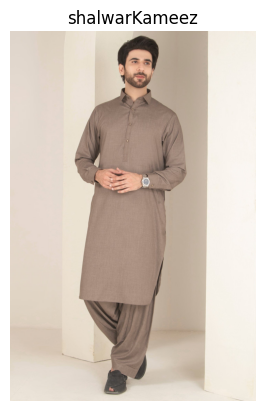

In [26]:
import matplotlib.image as mpimg
test_image_path = 'test/childd.jpg'  # Change the path to your test image
test_image = tf.keras.utils.load_img(test_image_path, target_size=(128, 128))
test_image = tf.keras.utils.img_to_array(test_image)
test_image = test_image.reshape(1, 128, 128, 3)
predictions = model.predict(test_image)

# Display the test image and prediction result
img = mpimg.imread(test_image_path)
plt.imshow(img)
plt.axis('off')
class_labels = ['ajrak', 'balochi','kalash', 'shalwarKameez']
predicted_class = class_labels[np.argmax(predictions)]
plt.title(predicted_class)
plt.show()